# Predicting Parole Violators #

## Key Takeaways: ##

- ** A **


- ** B **


- ** C **


- ** D **

### The Problem ###

In many societies, inmates who are likely no longer a threat to society are released from prison on "parole." The parole system allows the inmate to complete the remainder of his/her sentence outside of prison and requires the parolee to abide by certain terms and conditions. Parolees who violate these terms and conditions may be re-incarcerated. 

Parole boards must identify those inmates who are good candidates for parole. "Good candidates" are inmates who are unlikely to commit additional crimes once released and will abide by the terms of his/her parole.

Can data analytics assist parole boards in their efforts to identify such people?

(source: MITx)

### The Study ###

Here, we build and validate a model that predicts whether or not an inmate is likely to violate the terms of his/her parole to assist parole boards to determine whom to release.

(source: MITx)

### The Data ###

We will use data from the United States 2004 National Corrections Reporting Program -- a nationwide census of parole releases. The scope of our analysis is limited to parolees who served 1) no more than 6 months in prison and 2) whose maximum sentence for all charges was less than 18 months. The dataset contains information about both parolees who completed their parole in 2004, as well as those who violated the terms of their parole in the same year.

Our dataset contains the following predictors: 

**male**: 1 if the parolee is male, 0 if female

**race**: 1 if the parolee is white, 2 otherwise

**age**: the parolee's age (in years) when he or she was released from prison

**state**: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.

**time.served**: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).

**max.sentence**: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).

**multiple.offenses**: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.

**crime**: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving-related crime, and 1 is any other crime.

**violator**: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.

(source: MITx)

In [35]:
install.packages("ggplot2")
install.packages("corrplot")
install.packages("tidyverse")
install.packages("remotes")
install.packages("caTools")
install.packages("ROCR")
install.packages("data.table")
install.packages("wesanderson")
library(wesanderson)
library(remotes)
library(tidyverse)
install_github("randy3k/collections")
library(corrplot)
library(ggplot2)
library(collections)
library(ROCR)
library(data.table)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Skipping install of 'collections' from a github remote, the SHA1 (117fff45) has not changed since last install.
  Use `force = TRUE` to force installation


### Data Structure ###

In [2]:
parole = read.csv("parole.csv")

In [3]:
str(parole)

'data.frame':	675 obs. of  9 variables:
 $ male             : int  1 0 1 1 1 1 1 0 0 1 ...
 $ race             : int  1 1 2 1 2 2 1 1 1 2 ...
 $ age              : num  33.2 39.7 29.5 22.4 21.6 46.7 31 24.6 32.6 29.1 ...
 $ state            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ time.served      : num  5.5 5.4 5.6 5.7 5.4 6 6 4.8 4.5 4.7 ...
 $ max.sentence     : int  18 12 12 18 12 18 18 12 13 12 ...
 $ multiple.offenses: int  0 0 0 0 0 0 0 0 0 0 ...
 $ crime            : int  4 3 3 1 1 4 3 1 3 2 ...
 $ violator         : int  0 0 0 0 0 0 0 0 0 0 ...


### Data Summary ###

In [4]:
summary(parole)

      male             race            age            state      
 Min.   :0.0000   Min.   :1.000   Min.   :18.40   Min.   :1.000  
 1st Qu.:1.0000   1st Qu.:1.000   1st Qu.:25.35   1st Qu.:2.000  
 Median :1.0000   Median :1.000   Median :33.70   Median :3.000  
 Mean   :0.8074   Mean   :1.424   Mean   :34.51   Mean   :2.887  
 3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:42.55   3rd Qu.:4.000  
 Max.   :1.0000   Max.   :2.000   Max.   :67.00   Max.   :4.000  
  time.served     max.sentence   multiple.offenses     crime      
 Min.   :0.000   Min.   : 1.00   Min.   :0.0000    Min.   :1.000  
 1st Qu.:3.250   1st Qu.:12.00   1st Qu.:0.0000    1st Qu.:1.000  
 Median :4.400   Median :12.00   Median :1.0000    Median :2.000  
 Mean   :4.198   Mean   :13.06   Mean   :0.5363    Mean   :2.059  
 3rd Qu.:5.200   3rd Qu.:15.00   3rd Qu.:1.0000    3rd Qu.:3.000  
 Max.   :6.000   Max.   :18.00   Max.   :1.0000    Max.   :4.000  
    violator     
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000

Below we recode some of our numerical data as factors to facilitate our analytics.

In [5]:
parole2 = as.data.frame(parole)
parole2$state = as.factor(parole2$state)
parole2$sex = as.factor(parole2$male)
parole2$race = as.factor(parole2$race)
parole2$violator = as.factor(parole2$violator)
parole2$crime = as.factor(parole2$crime)
parole2$male = NULL
parole2$multiple.offenses = as.factor(parole2$multiple.offenses)

In [6]:
parole2 = parole2 %>% mutate(sex=recode(sex, 
                        `1`='Male',
                        `0`="Female"),
                        race=recode(race, `1` = "White", `2` = "NonWhite"),
                        state=recode(state, `2` = "KY", `3` = "LA", `4` = "VA", `1` = "All Other States"),
                        multiple.offenses=recode(multiple.offenses, `1` = "Yes", `0` = "No"),
                        violator=recode(violator, `1` = "Yes", `0` = "No"),
                        crime=recode(crime, `1` = "Other", `2` = "Larceny", `3`="Drugs", `4`="Vehicular")
)

### Exploratory Data Analysis ###

The correlation matrix below suggests multicollinearity will not be a problem during the modeling phase. In all cases, correlation coefficients among the variables fall below the .70 threshold we use for variable elimination. 

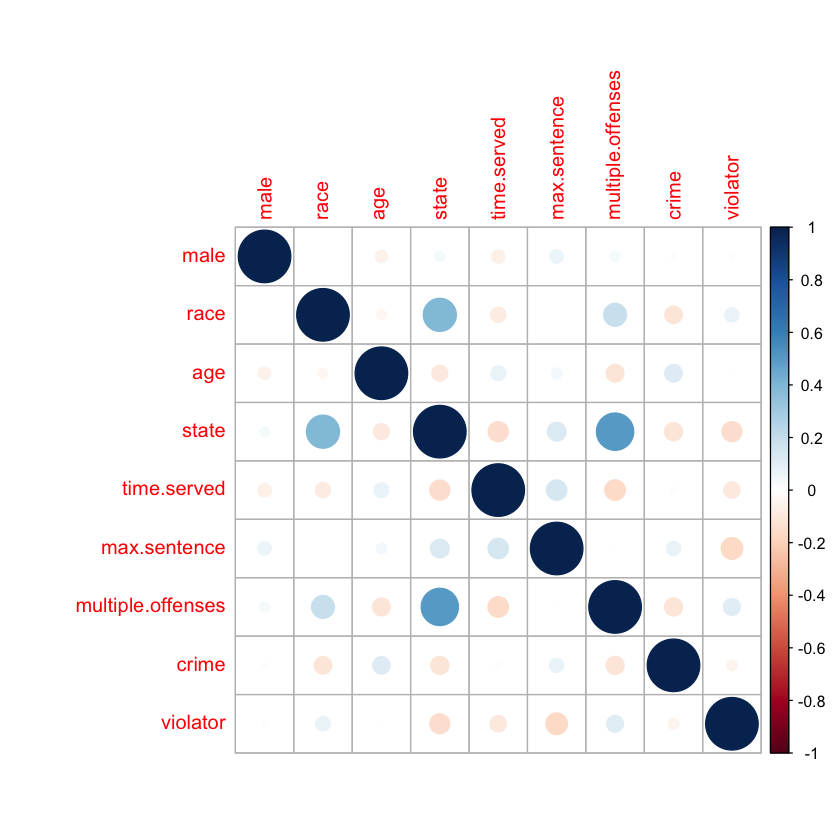

In [7]:
corrplot(cor(parole, use="complete.obs"))

In [8]:
state_sex = parole2 %>%
  group_by(state, sex) %>%
  summarise (n = n()) %>%
  mutate(Percentage = n / sum(n))
state_sex

state,sex,n,Percentage
<fct>,<fct>,<int>,<dbl>
All Other States,Female,23,0.1608392
All Other States,Male,120,0.8391608
KY,Female,35,0.2916667
KY,Male,85,0.7083333
LA,Female,18,0.2195122
LA,Male,64,0.7804878
VA,Female,54,0.1636364
VA,Male,276,0.8363636


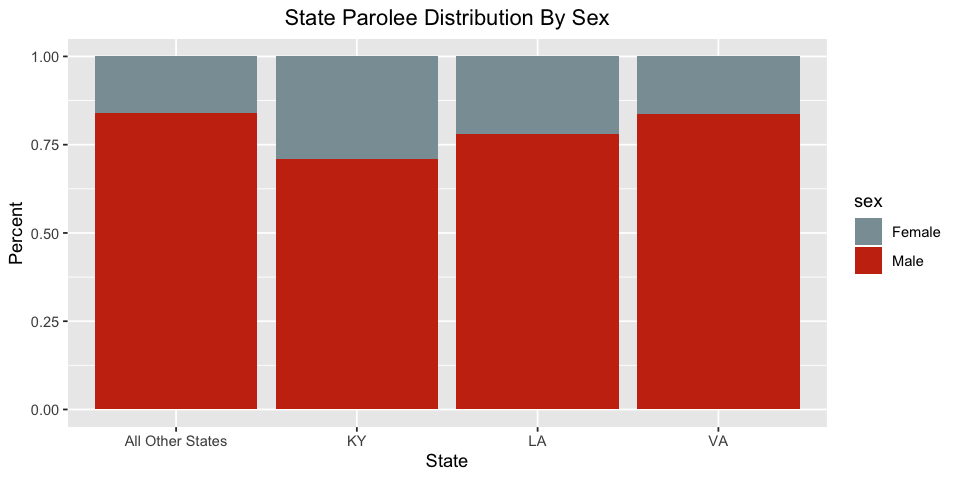

In [69]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot() + 
    geom_bar(aes(x = state, y = Percentage, fill = sex), data = state_sex,stat="identity") +
    scale_fill_manual(values=wes_palette(n=2, name="Royal1")) +
    ggtitle("State Parolee Distribution By Sex") +
    theme(plot.title = element_text(hjust=.5)) +
    xlab("State") +
    ylab("Percent")

In [10]:
state_race = parole2 %>%
  group_by(state, race) %>%
  summarise (n = n()) %>%
  mutate(Percentage = n / sum(n))
state_race

state,race,n,Percentage
<fct>,<fct>,<int>,<dbl>
All Other States,White,123,0.8601399
All Other States,NonWhite,20,0.1398601
KY,White,98,0.8166667
KY,NonWhite,22,0.1833333
LA,White,30,0.3658537
LA,NonWhite,52,0.6341463
VA,White,138,0.4181818
VA,NonWhite,192,0.5818182


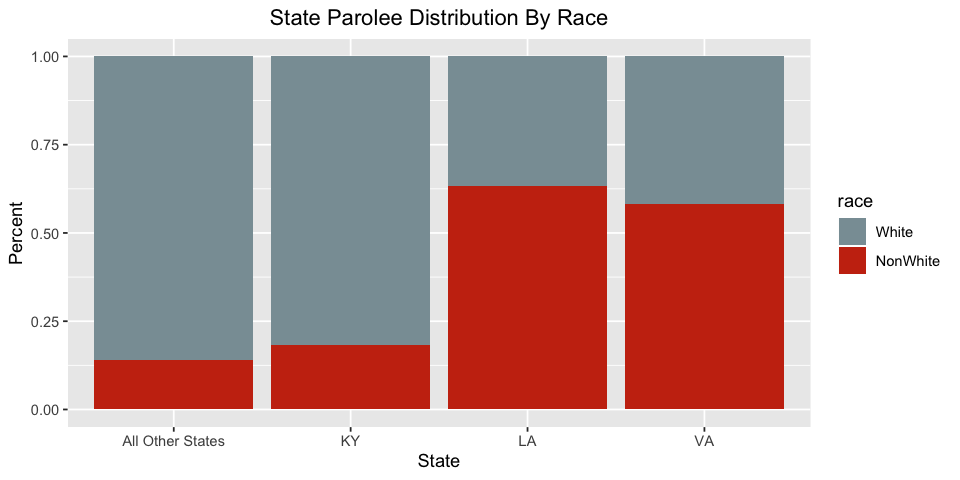

In [68]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot() + 
    geom_bar(aes(x = state, y = Percentage, fill = race), data = state_race, stat="identity") +
    scale_fill_manual(values=wes_palette(n=2, name="Royal1")) +
    ggtitle("State Parolee Distribution By Race") +
    theme(plot.title = element_text(hjust=.5)) +
    xlab("State") +
    ylab("Percent")

In [12]:
# stacked bar chart
state_crime = parole2 %>%
  group_by(state, crime) %>%
  summarise (n = n()) %>%
  mutate(Percentage = n / sum(n))
state_crime

state,crime,n,Percentage
<fct>,<fct>,<int>,<dbl>
All Other States,Other,66,0.46153846
All Other States,Larceny,9,0.06293706
All Other States,Drugs,34,0.23776224
All Other States,Vehicular,34,0.23776224
KY,Other,42,0.35000000
KY,Larceny,10,0.08333333
KY,Drugs,64,0.53333333
KY,Vehicular,4,0.03333333
LA,Other,42,0.51219512


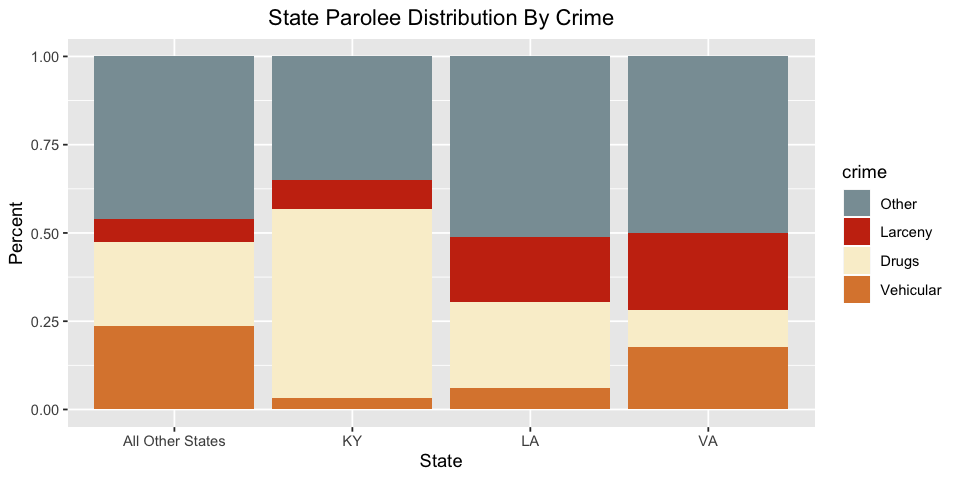

In [66]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot() + 
    geom_bar(aes(x = state, y = Percentage, fill = crime), data = state_crime, stat="identity") +
    scale_fill_manual(values=wes_palette(n=4, name="Royal1")) +
    ggtitle("State Parolee Distribution By Crime") +
    theme(plot.title = element_text(hjust=.5)) +
    xlab("State") +
    ylab("Percent")

In [14]:
# side-by-side bar chart
state_MultiOffender = parole %>%
    group_by(state) %>%
    summarise_each(mean, multiple.offenses, violator)
state_MultiOffender

state,multiple.offenses,violator
<int>,<dbl>,<dbl>
1,0.2657343,0.13986014
2,0.1083333,0.11666667
3,0.6707317,0.45121951
4,0.7757576,0.02121212


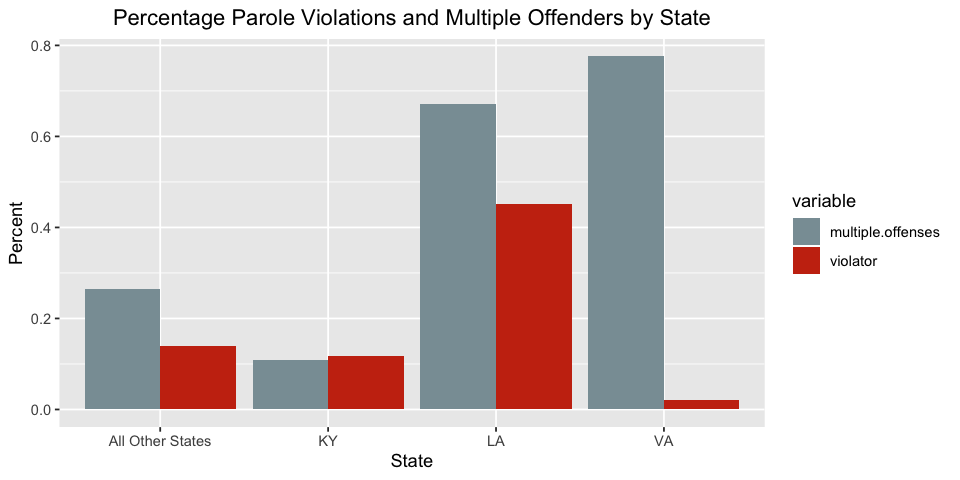

In [76]:
state_offender = melt(state_MultiOffender, id.vars = "state")

options(repr.plot.width=8, repr.plot.height=4)
ggplot(state_offender, aes(x = factor(state), y = value, fill = variable)) +
    geom_col(position = "dodge") +
    scale_fill_manual(values=wes_palette(n=4, name="Royal1")) +
    ggtitle("Percentage Parole Violations and Multiple Offenders by State") +
    theme(plot.title = element_text(hjust=.5)) +
    scale_x_discrete(breaks=c("1","2","3","4"), labels=c("All Other States", "KY", "LA", "VA"))+
    xlab("State") +
    ylab("Percent")

In [24]:
# side by side bar chart
pct_timeServed = parole %>% 
    mutate(PCT_Served = time.served/max.sentence)%>%
    group_by(state) %>%
    summarise_each(mean, PCT_Served, violator)
pct_timeServed

state,PCT_Served,violator
<int>,<dbl>,<dbl>
1,0.3528689,0.13986014
2,0.3890079,0.11666667
3,0.5948477,0.45121951
4,0.2896138,0.02121212


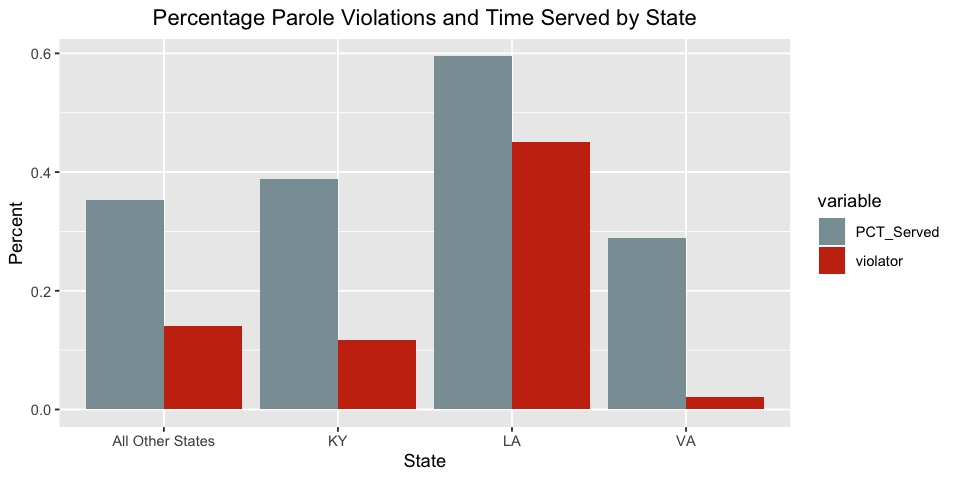

In [77]:
state_time_served = melt(pct_timeServed, id.vars = "state")

options(repr.plot.width=8, repr.plot.height=4)
ggplot(state_time_served, aes(x = factor(state), y = value, fill = variable)) +
    geom_col(position = "dodge") +
    scale_fill_manual(values=wes_palette(n=4, name="Royal1")) +
    ggtitle("Percentage Parole Violations and Time Served by State") +
    theme(plot.title = element_text(hjust=.5)) +
    scale_x_discrete(breaks=c("1","2","3","4"), labels=c("All Other States", "KY", "LA", "VA"))+
    xlab("State") +
    ylab("Percent")
    

### The Model ###

We begin the modeling process by splitting our data into a training and test sets. The dispersion of the response variable suggests a 70/30 split is appropriate.

In [ ]:
parole$state = as.factor(parole$state)
parole$crime = as.factor(parole$crime)
set.seed(144)
split = sample.split(parole$violator, .7)
train = subset(parole, split == TRUE)
test = subset(parole, split == FALSE)

Next, we calculate a baseline accuracy rate for a model that predicts the most frequent outcome in what will be our test data set.

In [ ]:
cat(paste("The accuracy of our model baseline model is ", round(addmargins(table(test$violator))[[1]]/addmargins(table(test$violator))[[3]],4),".", sep=""))

Our response variable, violator, is binary. Logistic regression, therefore, seems to be an appropriate choice for a model.  

In [ ]:
summary(train)

In [ ]:
logistic1 = glm(violator ~ ., data=train, family="binomial")

In [ ]:
summary(logistic1)

Coefficients from our model indicate non-whites are 2.42 times more likely to violate parole than whites, and inmates who have committed multiple offenses are 5.01 times more likely to violate the terms of their parole. 

The state of Virginia presents an interesting case. Virginian inmates are only .033 times more likely to violate parole than parolees in other states. 

Virginia is among the top ten wealthiest and most educated states in the US. While We cannot state definitively why Virginian inmates -- even those who have committed multiple offenses -- are inclined to abide by the terms of their parole, we conjecture the state's wealth has enabled it to dedicate ample resources to support and monitor parolees upon release.  

Below we predict over the test set, present summary data, and our confusion matrix. Note that the maximum predicted probability of violation is .9072.

In [ ]:
predTest = predict(logistic1, newdata=test, type="response")

In [ ]:
summary(predTest)

In [ ]:
cmtx=addmargins(table(test$violator, as.numeric(predTest > .5)))
cmtx

Diagnostic statistics for our model based on the confusion matrix above are as follows:

In [ ]:
cat(paste("The sensitivity of our model is ", round(cmtx[[5]]/cmtx[[8]],4),".", sep=""))

In [ ]:
cat(paste("The specificity of our model is ", round(cmtx[[1]]/cmtx[[7]],4),".", sep=""))

In [ ]:
cat(paste("The accuracy of our model is ", round((cmtx[[1]]+cmtx[[5]])/cmtx[[9]],4),".", sep=""))

Recall that the accuracy of our baseline model is identical to the accuracy obtained by our model using a threshold of .5. Our threshold, however, failed to contemplate the broader context in which we were modelling. A parole board has a higher tolerance for false positives (i.e., non-violators misclassified as parole violators) than it does false negatives (i.e., parole violators classified as non-violators). Decreasing the threshold will better reflect the preferences of the parole board, reduce the number of false negatives, increase the number of false positives, and improve the accuracy of our model for its intended purpose.

Here, we calculate the AUC value for the model with respect to the Receiver Operator Characteristic Curve.

In [ ]:
pred = prediction(predTest, test$violator)
cat(paste("The AUC value for our model is ",round(as.numeric(performance(pred, "auc")@y.values),4),".", sep=""))

The AUC for any model is evaluated relative to a banchmark value of .5 (i.e., a coin toss). Our model produced a value significantly higher than the benchmark indicating it can correctly differentiate between parole violators and non-violators who have both been selected at random.

### Beyond the Assignment: Can we do better? ###

We ask ourselves this question after each assignment, usually with an eye towards imporving the parsimony of our model, an aspect of data analytics not overly emphasized in this class, but one learned in undergraduate (William & Mary) and graduate (UW-Madison) coursework in statistics. 

In this instance, we can answer the above question with a responding "Yes! We can do better!"

Below is our revised model consisting only of statistically significant variables. Note that our AIC has decreased, thus indicating that our model quality has improved.

In [ ]:
logistic2 = glm(violator ~ male+race+state+multiple.offenses, data=train, family="binomial")

In [ ]:
summary(logistic2)

In [ ]:
predTest2 = predict(logistic2, newdata=test, type="response")

While the summary data for the model wouldn't outherwise be terrible remarkable, the maximum predicted probability has dropped significantly. This tends to speak of a higher level of certainty, which is supported by the numbers below. 

In [ ]:
summary(predTest2)

In [ ]:
cmtx3=addmargins(table(test$violator, as.numeric(predTest2 > .5)))
cmtx3

Our revised model maintains the sensitivity and specificty of the original, but is now more accurate than the baseline, even at an arbitrarily chosen threshold of .5! 

In [ ]:
cat(paste("The sensitivity of our model is ", round(cmtx3[[5]]/cmtx3[[8]],4),".", sep=""))

In [ ]:
cat(paste("The specificity of our model is ", round(cmtx3[[1]]/cmtx3[[7]],4),".", sep=""))

In [ ]:
cat(paste("The accuracy of our model is ", round((cmtx3[[1]]+cmtx3[[5]])/cmtx3[[9]],4),".", sep=""))

The news gets better still! The AUC for our second model increased to .905 from the original model's .894, thus, offering further evidence that this is *the* model with which the parole board should work. 

In [ ]:
pred2 = prediction(predTest2, test$violator)
cat(paste("The AUC value for our model is ",round(as.numeric(performance(pred2, "auc")@y.values),4),".", sep=""))

The key takeaway here is simple: Parsimony is not only a best practice, it can lead to unexpected gains in model quality, as measured by summary statistics like AIC, as well as model accuracy. 